# DSCI 100 - Report
### project-003-7: Nicole Campbell, Michelle Kim, Jason Liu, Zahra Raza

## Introduction

[WE NEED TO CHANGE THIS]
Our project is centered around factors that influence a student’s decision to pursue higher education based on academic performance. A student’s academic performance is often affected by different social and environmental factors. Thus, objective analysis on the relationship between those factors is critical to bolster maximum academic success. 
 
We will be working with the data set “Student Performance”, collected by Paulo Cortez at the University of Minho. The data set contains information gathered from students at two Portugese secondary students. The information collected includes student grades, social and study habits, and family background. The data set tracks first and second period grades as well as final grades in Portugese
 
We will try to answer the following question in this report:
Can we predict a student's study time, given Portuguese grades or math grades?

## Methods and Results

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

First, we loaded our data directly from the web (github). The origianal file includes both math and portuguese grades data as a separate csv files, but we only downloaded math grades data since we are only going to use math grades to predict students studytime.

As a part of wrangling and cleaning the data, we selected only the variables of interest out of 30 variables from the original data. 

1. studytime: weekly study time (numeric interval- 1 to <2 hours, 2 to <5 hours, 5 to <10 hours, >10 hours)
2. G1: first period grade (numeric value- from 0 to 20)
3. G2: second period grade (numeric value- from 0 to 20)
4. G3: final grade (numeric value- from 0 to 20)

Declared studytime as a factor since that is what we want to categorize students by their predicted study time based on their math grades.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.

`summarise()` ungrouping output (override with `.groups` argument)



studytime,n
<fct>,<int>
1,105
2,198
3,65
4,27


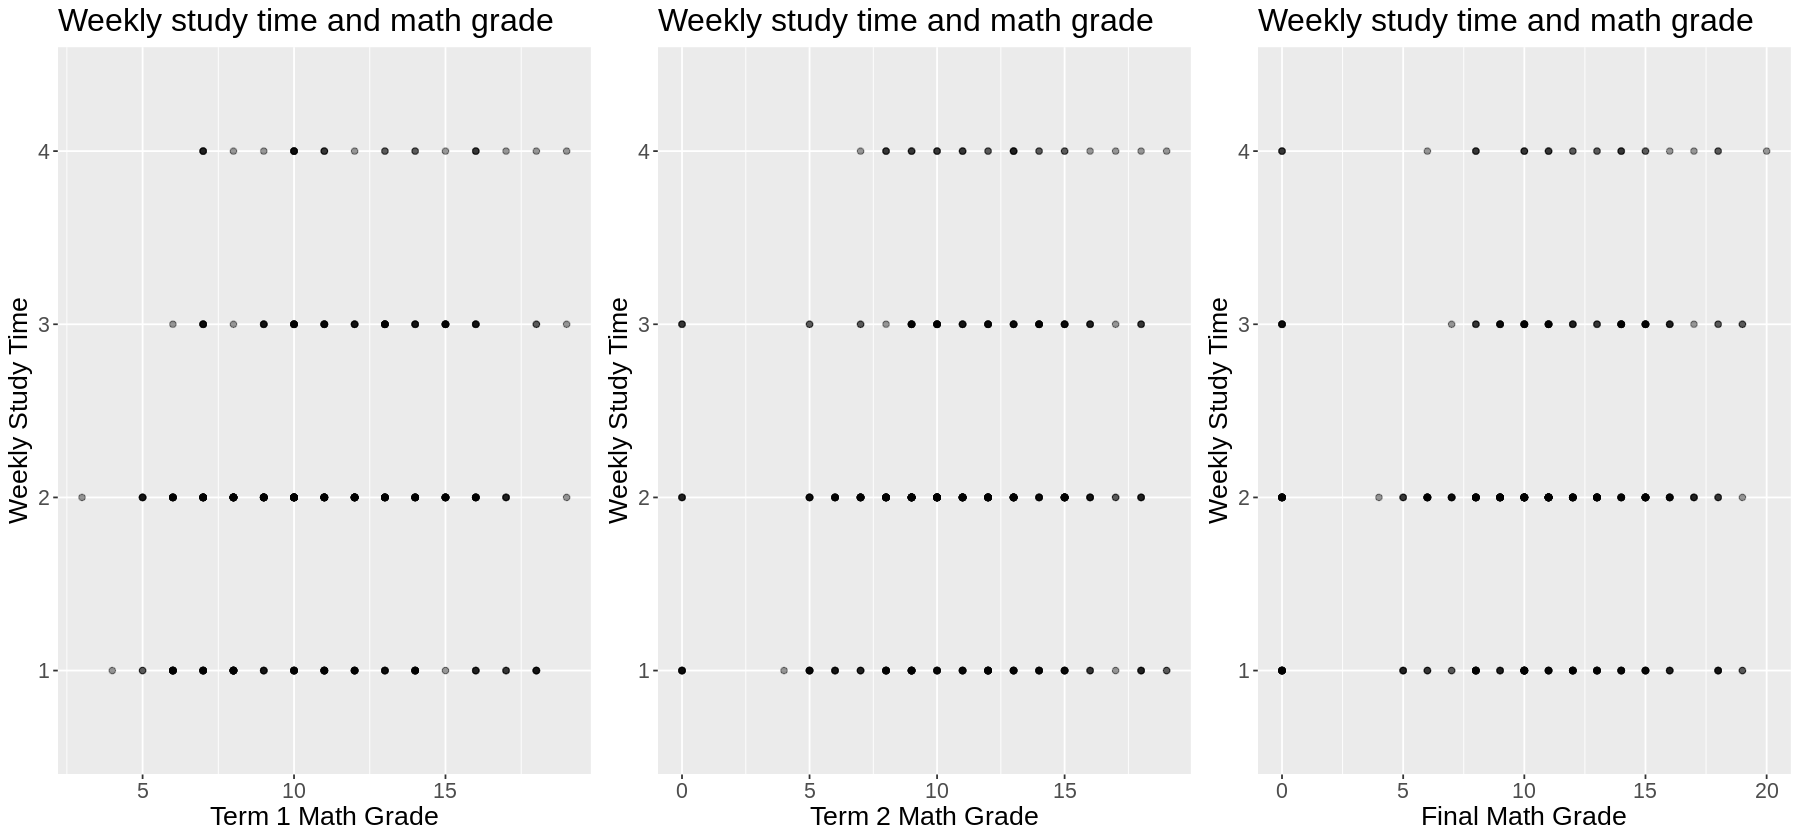

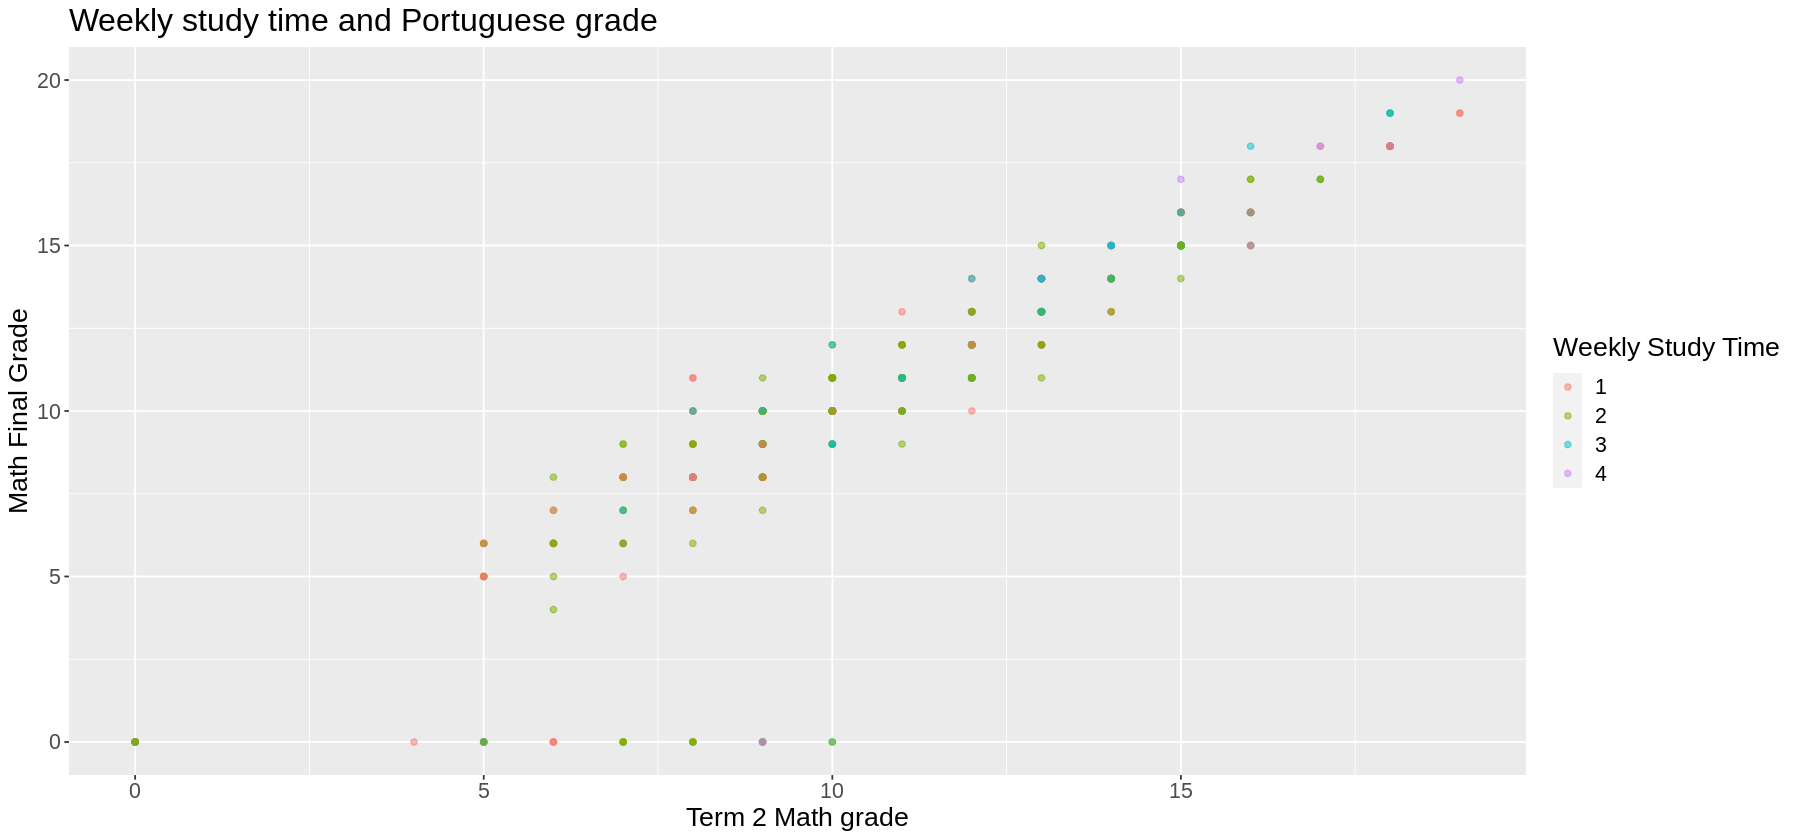

In [2]:
set.seed(300);

#Read data set from the web into R
student_mat <- read_delim("https://raw.githubusercontent.com/michelleykim/student_performance_analysis/main/data/student-mat.csv", delim = ";")

# Clean and wrangle data into tidy format
mat_select <- student_mat %>%
                select("studytime", "G1", "G2", "G3") %>%
                mutate(studytime = as_factor(studytime))

# number of observations in higher(target variable)
counts <- mat_select %>%
        group_by(studytime) %>%
        summarize(n=n())   
counts

mat_plot_1 <- mat_select %>%
                ggplot(aes(x = G1, y = studytime)) + 
                geom_point(alpha = 0.4)+
                labs(x = "Term 1 Math Grade", 
                     y = "Weekly Study Time", 
                     title = "Weekly study time and math grade")+
                theme(text = element_text(size=16))  
mat_plot_2 <- mat_select %>%
                ggplot(aes(x = G2, y = studytime)) + 
                geom_point(alpha = 0.4)+
                labs(x = "Term 2 Math Grade", 
                     y = "Weekly Study Time", 
                     title = "Weekly study time and math grade")+
                theme(text = element_text(size=16))  
mat_plot_3 <- mat_select %>%
                ggplot(aes(x = G3, y = studytime)) + 
                geom_point(alpha = 0.4)+
                labs(x = "Final Math Grade", 
                     y = "Weekly Study Time", 
                     title = "Weekly study time and math grade")+
                theme(text = element_text(size=16))  

student_por_plot2 <- mat_select %>%
                select(G2, G3, studytime) %>%
                ggplot(aes(x = G2, y = G3, colour = studytime)) + 
                geom_point(alpha = 0.5)+
                labs(x = "Term 2 Math grade", 
                     y = "Math Final Grade", 
                     colour = "Weekly Study Time", 
                     title = "Weekly study time and Portuguese grade")+
                theme(text = element_text(size=16))  

options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(mat_plot_1, mat_plot_2, mat_plot_3, ncol = 3)

student_por_plot2

Then we splitted the wrangled data into training and testing sets. We used prop = 0.75 since the dataset in total has 395 students which is small enough that we will get reasonable amount of trainign adn testing data with this split. 

We didn't scaled or centered the data since the original data was already scaled and centered by the institution. However, we overpopulated some datapoint to balance because the original dataset had significantly many students studying for 2 to <5 hours compared to other time intervals. 

For the K-NN classification, we decided to use 5-fold cross validation since we thought that using 5 validation sets would give us enough folding while not taking up too much time.

Then we plotted the accuracies for each choice of neighbours to choose the k value to predict the testing set. 

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


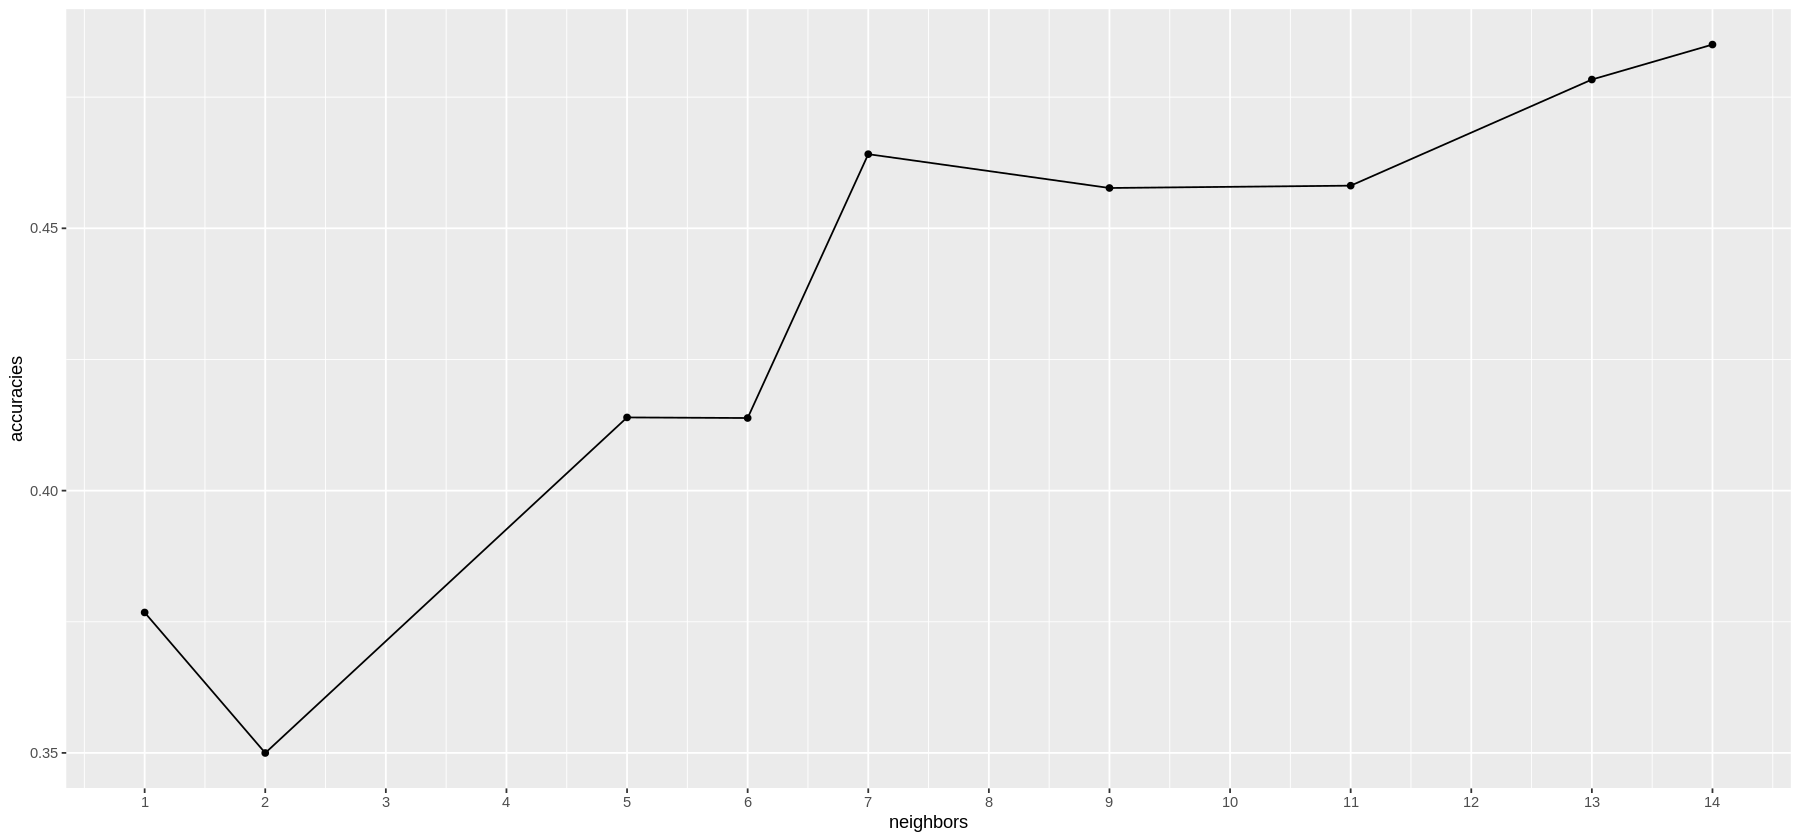

In [3]:
set.seed(300);

# Obtain training set:
# We chose prop= 0.75 since the data set is small enough that we will still 
# have a reasonable amount of training and testing data with this split.
mat_split <- initial_split(mat_select, prop = 0.75, strata = studytime) 
mat_train <- training(mat_split)
mat_test <- testing(mat_split)

# vfold_cv
mat_vfold <- vfold_cv(mat_train, v = 5, strata = studytime)

# balancing
mat_overpop_recipe <- recipe(studytime ~., data = mat_train) %>%
        step_upsample(studytime, over_ratio = 1, skip = FALSE) %>%
        prep()
mat_overpop <- bake(mat_overpop_recipe, mat_train)

#recipe
mat_recipe <- recipe(studytime ~., data = mat_overpop)

# nearest_neighbour
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("classification")

# workflow & tune_grid
knn_workflow <- workflow() %>%
        add_recipe(mat_recipe) %>%
        add_model(knn_spec) %>%
        tune_grid(resamples = mat_vfold, grid = 10) %>%
        collect_metrics()

# produce accuracy graph to determine the k value
accuracies <- knn_workflow %>%
        filter(.metric == "accuracy")
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "neighbors", y = "accuracies") +
        scale_x_continuous(breaks = seq(0, 15, by = 1))

cross_val_plot

Based on the cross validation graph, the nearest_neighbor algorithm give the highest accuracy when 14 neighbors were used for prediction. However, we decided to use k = 7, since we were worried that using 14 neighbors would cause underfitting with out small dataset. Also, since the difference in accuracies between using 7 neighbors and 14 neighbours is small, both choice are potentially the optimal accuracy. 

Using the K value determined from the graph, we predict the studytime of testing set data and found the accuracy.

In [4]:
set.seed(300);

# nearest_neighbour with k = 7, workflow 
mat_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
        set_engine("kknn") %>%
        set_mode("classification")

mat_fit <- workflow() %>%
        add_recipe(mat_recipe) %>%
        add_model(mat_spec) %>%
        fit(data = mat_train)

# predict
mat_predictions <- predict(mat_fit, mat_test) %>%
        bind_cols(mat_test)

# maybe do metrics, conf_mat
mat_metrics <- mat_predictions %>%
        metrics(truth = studytime, estimate = .pred_class)
mat_conf_mat <- mat_predictions %>%
        conf_mat(truth = studytime, estimate = .pred_class)

# print
mat_predictions
mat_metrics
mat_conf_mat

.pred_class,studytime,G1,G2,G3
<fct>,<fct>,<dbl>,<dbl>,<dbl>
2,2,15,15,15
2,2,14,15,15
2,3,10,12,12
⋮,⋮,⋮,⋮,⋮
2,2,11,11,10
2,3,10,9,10
2,1,8,9,9


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5408163
kap,multiclass,0.1869469


          Truth
Prediction  1  2  3  4
         1 10  5  3  1
         2 14 41 12  4
         3  2  4  2  0
         4  0  0  0  0

## Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## Reference
P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. https://archive.ics.uci.edu/ml/datasets/Student+Performance#
